In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [29]:
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Load Dataset

In [30]:
data=pd.read_csv('datasets/tweets.csv')

### Check for null values

In [31]:
data.isnull().sum()

tweets    0
labels    0
dtype: int64

In [32]:
#get stopword list
sw_list=stopwords.words('english')

### Since it might affect final outcome, a few words are removed from stopwords list

In [33]:
print(f"Not----->{'not' in sw_list}\nNo------>{'no' in sw_list}\nAgainst->{'against' in sw_list}")

Not----->True
No------>True
Against->True


In [34]:
sw_list.remove('not')
sw_list.remove('no')
sw_list.remove('against')

In [35]:
print(f"Not----->{'not' in sw_list}\nNo------>{'no' in sw_list}\nAgainst->{'against' in sw_list}")

Not----->False
No------>False
Against->False


In [36]:
#Initialize lemmatizer
lemmatizer=WordNetLemmatizer()

### Function to clean tweets

In [37]:
def nltk_wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:                    
    return None

In [38]:
def lemmatize_sentence(sentence):
    tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_wn_tag(x[1])), tagged)
    lemmatized_words=[]
    for word, tag in wordnet_tagged:
        if word not in sw_list:
            if tag is None:                        
                lemmatized_words.append(word)
            else:
                lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_words)
    

In [39]:
def clean_tweets(tweet):
    #remove RT(retweet tag)
    tweet=re.sub(r"RT @","@",tweet)
    #remove pings
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    #remove URLs
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    #remove special characters
    tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)
    #convert to lower case
    tweet=tweet.lower()
    #remove extra white spaces
    tweet = re.sub(r" +",' ', tweet)
    #lemmatization of tweet and removing stopwords
    lemmatized_tweet=lemmatize_sentence(tweet)
    #remove extra white spaces
    tweet = re.sub(r" +", ' ', tweet)
    return lemmatized_tweet.strip()


In [40]:
data['tweets']=[clean_tweets(tweet) for tweet in data['tweets']]

### Checking and Discarding tweets left empty after cleaning (tweets that contained only retweets, pings and URLs)

In [41]:
data[data['tweets']=='']

,tweets,labels
446,,0
905,,0
1067,,0
1082,,0
1093,,0
1101,,0
1290,,0


In [42]:
len(data)

1364

In [43]:
data.eq('').sum()

tweets    7
labels    0
dtype: int64

In [44]:
data.replace("",np.nan,inplace=True)
data.dropna(subset=['tweets'],inplace=True)
data.eq('').sum()

tweets    0
labels    0
dtype: int64

In [45]:
len(data)

1357

In [46]:
from sklearn.model_selection import train_test_split
X=data['tweets']
y=data['labels']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)

In [47]:
lengths=pd.DataFrame(len(tweet.split(' ')) for tweet in X_train)

In [48]:
test_length=pd.DataFrame(len(tweet.split(' ')) for tweet in X_test)

In [49]:
max_len=max(len(tweet.split(' ')) for tweet in X_train)

### Get word count of tweet with most words

In [50]:
max_len

24

## Modeled using : max_features=max_len

### TF-IDF Vectorization

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
tfidf_vect=TfidfVectorizer(max_features=max_len)
X_train_tfidf=tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf=tfidf_vect.transform(X_test).toarray()
X_train_tfidf=pd.DataFrame(X_train_tfidf)
X_test_tfidf=pd.DataFrame(X_test_tfidf)

### Combined dataframe of training data

In [53]:
train_data=pd.concat((X_train,y_train),axis=1,ignore_index=True)
train_data.columns=['tweets','labels']
train_data.reset_index(inplace=True,drop=True)
train_data=pd.concat((train_data,X_train_tfidf),axis=1)
train_data

,tweets,labels,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,obama admin cry tax increase applaud china low...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.964659,0.0,0.0,0.0,0.000000
1,barack obama longboard package core truck mm b...,0,0.0,0.966024,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,edshow whenever obama tell truth gop boo hoo h...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.96201,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
3,many foreign leader obama promise post electio...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.964659,0.0,0.0,0.0,0.000000
4,obama signal us would accept iranian civilian ...,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,mean saving scotus tell world obama wrong aca ...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
1081,obama sharpen kansas vision,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
1082,genius man sing else really obama,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
1083,mitt romney obama spend much time harvard also...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.63229,0.0,0.000000,0.0,0.0,0.0,0.749274


### Combined dataframe of test data

In [54]:
test_data=pd.concat((X_test,y_test),axis=1,ignore_index=True)
test_data.columns=['tweets','labels']
test_data.reset_index(inplace=True,drop=True)
test_data=pd.concat((test_data,X_test_tfidf),axis=1)
test_data

,tweets,labels,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,harry style describe michelle obama como una m...,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,amp si khady president obama get elect nyrell ...,0,0.000000,0.000000,0.0,0.000000,0.0,0.649992,0.0,0.0,...,0.0,0.536398,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,obama black american really need time whitey f...,0,0.954988,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,whatsromneyhiding throw baseball like man not ...,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.290948,0.0
4,realclearpolitics obama organizational advanta...,2,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,romney attack obama barnstorm pennsylvania,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.954745,0.0,0.0,0.0,0.0,0.000000,0.0
268,obama thug bully not sure call rush limbaugh bill,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
269,michelle barack obama become like celebrity ta...,0,0.000000,0.760224,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
270,whatsromneyhiding nothing compare mt proof oba...,1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.947853,0.0


In [55]:
y_train.unique()

array([0, 1, 2], dtype=int64)

In [56]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,3)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [58]:
tf.keras.backend.set_floatx('float64')

In [59]:
model=Sequential()
model.add(Dense(activation='relu',units=64))
model.add(Dropout(0.2))
model.add(Dense(activation='relu',units=32))
model.add(Dense(activation='softmax',units=3))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [60]:
history=model.fit(x=X_train_tfidf,y=y_train,epochs=20)

Epoch 1/20
34/34 [==============================] - 0s 862us/step - loss: 0.9106 - accuracy: 0.6682
Epoch 2/20
34/34 [==============================] - 0s 851us/step - loss: 0.7532 - accuracy: 0.6857
Epoch 3/20
34/34 [==============================] - 0s 703us/step - loss: 0.7209 - accuracy: 0.6949
Epoch 4/20
34/34 [==============================] - 0s 733us/step - loss: 0.7088 - accuracy: 0.7051
Epoch 5/20
34/34 [==============================] - 0s 587us/step - loss: 0.6906 - accuracy: 0.7143
Epoch 6/20
34/34 [==============================] - 0s 645us/step - loss: 0.6989 - accuracy: 0.7088
Epoch 7/20
34/34 [==============================] - 0s 733us/step - loss: 0.6877 - accuracy: 0.7198
Epoch 8/20
34/34 [==============================] - 0s 645us/step - loss: 0.6829 - accuracy: 0.7244
Epoch 9/20
34/34 [==============================] - 0s 616us/step - loss: 0.6795 - accuracy: 0.7134
Epoch 10/20
34/34 [==============================] - 0s 675us/step - loss: 0.6806 - accuracy: 0.7217

In [61]:
y_test=to_categorical(y_test,3)
y_predictions=(model.predict(X_test_tfidf) > 0.5).astype("int32")

In [62]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [63]:
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.73      0.95      0.83       182
           1       0.80      0.31      0.44        78
           2       0.00      0.00      0.00        12

   micro avg       0.74      0.72      0.73       272
   macro avg       0.51      0.42      0.42       272
weighted avg       0.72      0.72      0.68       272
 samples avg       0.72      0.72      0.72       272



In [64]:
print(accuracy_score(y_test,y_predictions))

0.7242647058823529


In [65]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[176,   6,   0],
       [ 54,  24,   0],
       [ 12,   0,   0]], dtype=int64)

In [66]:
losses=pd.DataFrame(history.history)

<AxesSubplot:>

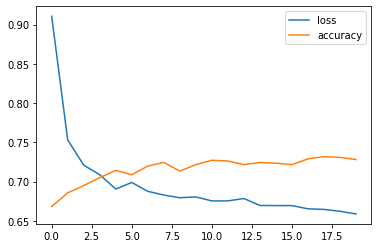

In [67]:
losses.plot()

## Modeled without: max_features=max_len

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer()
X_train_tfidf=tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf=tfidf_vect.transform(X_test).toarray()
X_train_tfidf=pd.DataFrame(X_train_tfidf)
X_test_tfidf=pd.DataFrame(X_test_tfidf)

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [70]:
model_2=Sequential()
model_2.add(Dense(activation='relu',units=64))
model_2.add(Dropout(0.2))
model_2.add(Dense(activation='relu',units=32))
model_2.add(Dense(activation='softmax',units=3))
model_2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [71]:
history_2=model_2.fit(x=X_train_tfidf,y=y_train,epochs=20)

Epoch 1/20
34/34 [==============================] - 0s 5ms/step - loss: 0.9680 - accuracy: 0.6452
Epoch 2/20
34/34 [==============================] - 0s 4ms/step - loss: 0.7193 - accuracy: 0.6848
Epoch 3/20
34/34 [==============================] - 0s 4ms/step - loss: 0.5868 - accuracy: 0.7484
Epoch 4/20
34/34 [==============================] - 0s 5ms/step - loss: 0.4704 - accuracy: 0.8046
Epoch 5/20
34/34 [==============================] - 0s 4ms/step - loss: 0.3570 - accuracy: 0.8608
Epoch 6/20
34/34 [==============================] - 0s 4ms/step - loss: 0.2673 - accuracy: 0.9041
Epoch 7/20
34/34 [==============================] - 0s 4ms/step - loss: 0.2054 - accuracy: 0.9309
Epoch 8/20
34/34 [==============================] - 0s 4ms/step - loss: 0.1544 - accuracy: 0.9530
Epoch 9/20
34/34 [==============================] - 0s 4ms/step - loss: 0.1148 - accuracy: 0.9650
Epoch 10/20
34/34 [==============================] - 0s 4ms/step - loss: 0.0831 - accuracy: 0.9843
Epoch 11/20
34/34 [

In [72]:
y_predictions=(model_2.predict(X_test_tfidf) > 0.5).astype("int32")

In [73]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       182
           1       0.80      0.71      0.75        78
           2       0.83      0.42      0.56        12

   micro avg       0.85      0.85      0.85       272
   macro avg       0.83      0.69      0.74       272
weighted avg       0.85      0.85      0.85       272
 samples avg       0.85      0.85      0.85       272



In [74]:
print(accuracy_score(y_test,y_predictions))

0.8529411764705882


In [75]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[172,  10,   0],
       [ 22,  55,   1],
       [  3,   4,   5]], dtype=int64)

<AxesSubplot:>

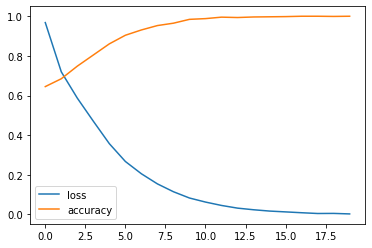

In [76]:
losses=pd.DataFrame(history_2.history)
losses.plot()